## TODO

- Replace the predicted column from AMERCL_BID to AMERHI_BID and AMERLO_BID for better price estimations.
- Use a better model to smooth out the graph used to calculate derivatives
- Try ARIMA if someone knows the math

In [ ]:
import pandas as pd
import requests
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
# Data Science Accelerator Credentials 
RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" 
access_token = 'tUn7ZD2ZsW9jKiFpoS56ua2g3hnLaUEE8A1nE6cQ'

In [3]:
ric = 'JPY=' # put the RIC of the asset you want to retrieve data

requestData = {
    'interval': 'P1D',
    'start': '2016-11-01',
    'end': '2019-06-30',
    #"fields": 'TRDPRC_1' # Uncomment this line if you wish to specify which fields to be returned, e.g. TRDPRC_1 is an available field for AAPL.O
};

In [4]:
def get_data_request(url, requestData):
    """
    HTTP GET request to Refinitiv API
    
    There is more information in the returned dict (i.e. json) object from the API, we store the data in a DataFrame.
    
    :param url: str, the url of the API endpoint
    :param requestData: dict, contains user-defined variables
    :return: DataFrame, containing the historical pricing data. 
        Returned field list order and content can vary depending on the exchange / instrument.
        Therefore returned data must be treated using appropriate parsing techniques.
    """
    dResp = requests.get(url, headers = {'X-api-key': access_token}, params = requestData);       

    if dResp.status_code != 200:
        raise ValueError("Unable to get data. Code %s, Message: %s" % (dResp.status_code, dResp.text));
    else:
        print("Data access successful")
        jResp = json.loads(dResp.text);
        data = jResp[0]['data']
        headers = jResp[0]['headers']  
        names = [headers[x]['name'] for x in range(len(headers))]
        df = pd.DataFrame(data, columns=names )
        return df
    
resource_endpoint_ric = RESOURCE_ENDPOINT + ric  
df = get_data_request(resource_endpoint_ric, requestData)

Data access successful


In [5]:
print(df.shape)
df.head(10)

(694, 23)


,DATE,BID,ASK,BID_HIGH_1,BID_LOW_1,OPEN_BID,MID_PRICE,NUM_BIDS,ASK_LOW_1,ASK_HIGH_1,ASIAOP_BID,ASIAHI_BID,ASIALO_BID,ASIACL_BID,EUROP_BID,EURHI_BID,EURLO_BID,EURCL_BID,AMEROP_BID,AMERHI_BID,AMERLO_BID,AMERCL_BID,OPEN_ASK
0,2019-06-28,107.88,107.91,107.93,107.55,107.78,107.895,91894.0,107.57,107.96,107.78,107.83,107.55,107.64,107.63,107.85,107.58,107.84,107.66,107.93,107.62,107.88,107.81
1,2019-06-27,107.78,107.81,108.15,107.63,107.78,107.795,94057.0,107.66,108.18,107.78,108.15,107.63,108.04,108.05,108.15,107.66,107.72,107.82,107.94,107.66,107.78,107.81
2,2019-06-26,107.77,107.80,107.84,107.08,107.18,107.785,81259.0,107.11,107.87,107.18,107.50,107.08,107.46,107.47,107.75,107.35,107.63,107.67,107.84,107.58,107.77,107.21
3,2019-06-25,107.17,107.20,107.40,106.77,107.29,107.185,98267.0,106.79,107.43,107.29,107.40,106.77,107.03,106.81,107.14,106.80,106.91,106.97,107.39,106.82,107.17,107.30
4,2019-06-24,107.28,107.31,107.53,107.23,107.39,107.295,86297.0,107.26,107.55,107.39,107.48,107.26,107.39,107.42,107.53,107.23,107.35,107.29,107.53,107.23,107.28,107.40
5,2019-06-21,107.30,107.33,107.73,107.04,107.30,107.315,103704.0,107.06,107.76,107.30,107.52,107.04,107.45,107.09,107.73,107.05,107.54,107.55,107.73,107.29,107.30,107.33
6,2019-06-20,107.29,107.32,108.13,107.20,108.08,107.305,104670.0,107.23,108.16,108.08,108.13,107.45,107.66,107.63,107.87,107.45,107.50,107.77,107.79,107.20,107.29,108.11
7,2019-06-19,108.09,108.12,108.61,107.89,108.44,108.105,84189.0,107.91,108.63,108.44,108.61,108.22,108.37,108.34,108.49,108.22,108.36,108.39,108.49,107.89,108.09,108.47
8,2019-06-18,108.44,108.47,108.67,108.05,108.53,108.455,83698.0,108.07,108.69,108.53,108.58,108.20,108.24,108.33,108.67,108.05,108.39,108.29,108.67,108.05,108.44,108.56
9,2019-06-17,108.55,108.56,108.72,108.40,108.44,108.555,65604.0,108.43,108.75,108.44,108.70,108.40,108.56,108.59,108.72,108.51,108.56,108.68,108.72,108.50,108.55,108.43


In [6]:
df['DATE'] = pd.to_datetime(df['DATE']).astype('O')

#test set
df_test = df[df['DATE']>pd.to_datetime('2019-01-30')]

df_train = df[df['DATE']<=pd.to_datetime('2019-01-30')]


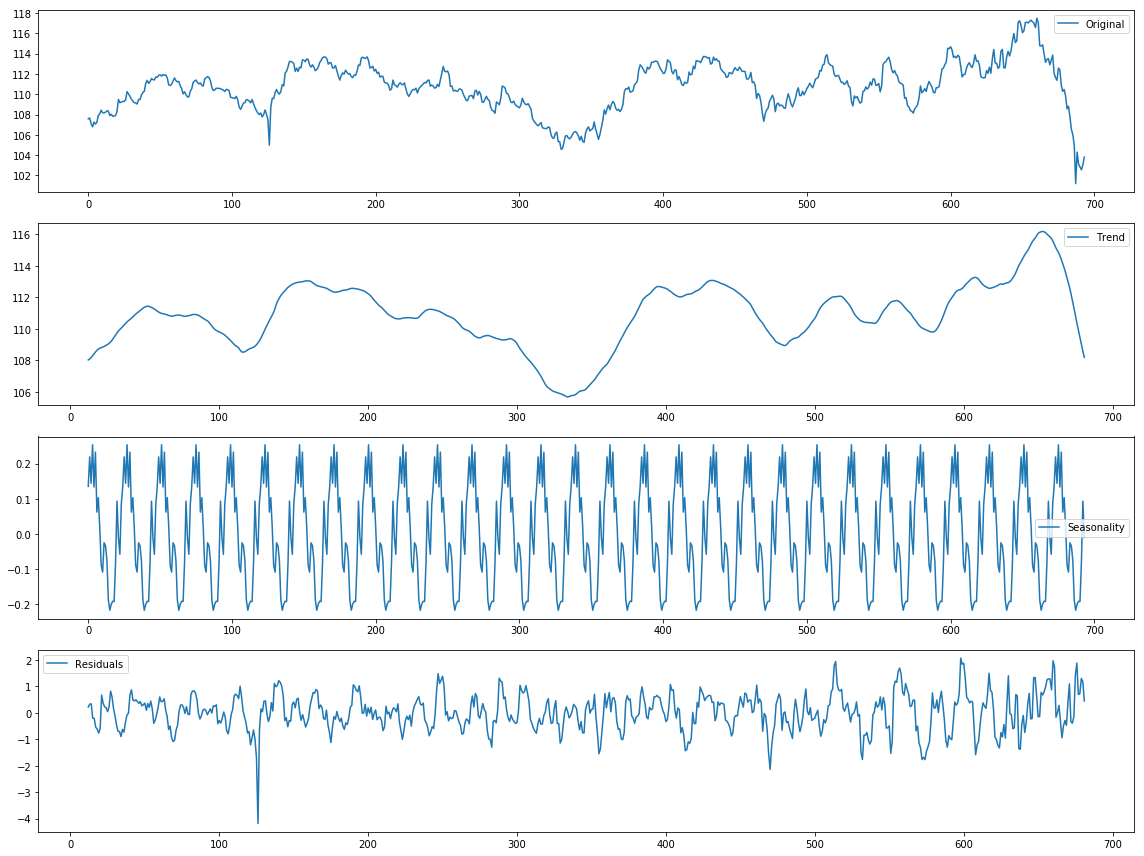

In [7]:
# Change ME!
target = df.ASK_LOW_1
    
decomposition = seasonal_decompose(target, freq=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f = plt.figure(figsize=(16,12))
plt.subplot(411)
plt.plot(target, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [152]:
# Looking for about 99% Confidence

for col in df:
    if col != 'DATE':
        adf_res = adfuller(df[col], autolag='AIC')
        print('ADF Statistic for %s: %f' % (col, adf_res[0]))
        print('p-value: %f' % adf_res[1])
        print('Critical Values:')
        for key, value in adf_res[4].items():
            print('\t%s: %.3f' % (key, value))

ADF Statistic for BID: -3.561211
p-value: 0.006547
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
ADF Statistic for ASK: -3.567876
p-value: 0.006406
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
ADF Statistic for BID_HIGH_1: -3.445424
p-value: 0.009504
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
ADF Statistic for BID_LOW_1: -2.727824
p-value: 0.069346
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
ADF Statistic for OPEN_BID: -3.598391
p-value: 0.005792
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
ADF Statistic for MID_PRICE: -3.564646
p-value: 0.006474
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
ADF Statistic for NUM_BIDS: -3.611701
p-value: 0.005541
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
ADF Statistic for ASK_LOW_1: -2.730763
p-value: 0.068865
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
ADF Statistic for ASK_HIGH_1: -3.449044
p-value: 0.009396
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
ADF Statistic

In [8]:
data = df_train[['DATE', 'AMERCL_BID']]
data.set_index('DATE', inplace=True)
data = data.resample('D',label='right').ffill()
test_data = df_test[['DATE','AMERCL_BID']]
test_data.set_index('DATE', inplace=True)
idx = pd.date_range('2019-02-01', '2019-06-28')
test_data = test_data.reindex(idx).ffill()


#Hyperparameters: p
es_model = ExponentialSmoothing(data, trend='add' , damped=True, seasonal='add', seasonal_periods=325) #p
es_results = es_model.fit()

#CHANGE ME!
pred= es_results.forecast(148)
xhat = pred.get_values()

z = 1.96
sse = es_results.sse

predint_xminus = xhat - z * np.sqrt(sse/len(data))
predint_xplus  = xhat + z * np.sqrt(sse/len(data))

upper_pi_data = pd.DataFrame( 
    data  = predint_xplus, 
    index = test_data.index)

lower_pi_data = pd.DataFrame( 
    data  = predint_xminus, 
    index = test_data.index)

C:\Users\total\AppData\Roaming\Python\Python35\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


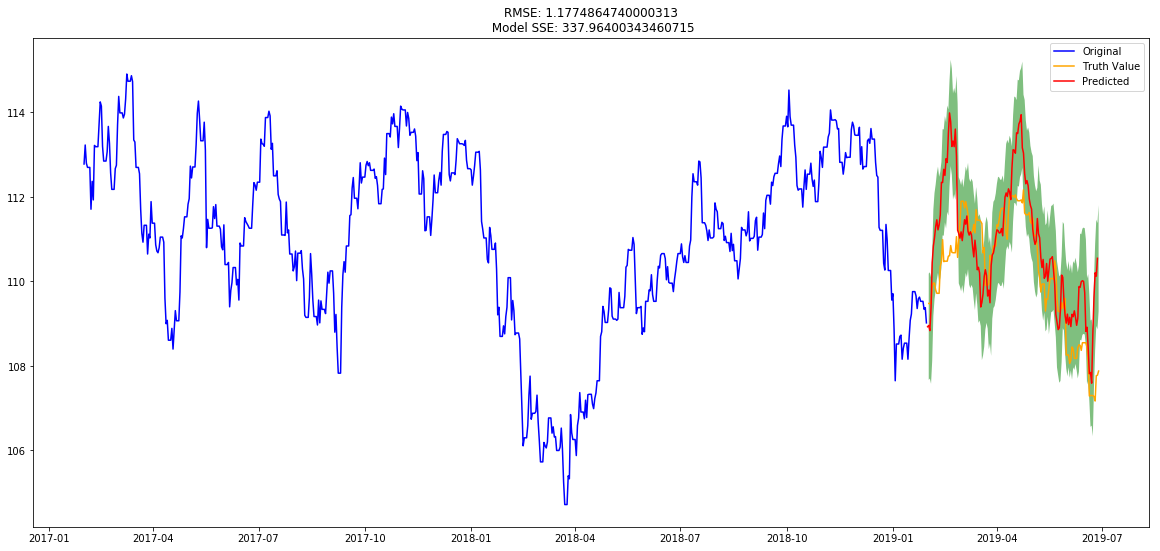

In [9]:
plt.figure(figsize=(20,9))
plt.plot(data[data.index>'2017-01-30'], label='Original', color='blue')
plt.plot(test_data, label='Truth Value', color='orange')
plt.plot(pred, label='Predicted', color='red')
plt.fill_between(test_data.index, predint_xminus, predint_xplus, facecolor='green', alpha=0.5)
plt.legend(loc='best')
plt.title("RMSE: " + str(np.sqrt(mean_squared_error(test_data, pred))) + "\n Model SSE: " + str(es_results.sse))
plt.show()

## Buy/Sell Strategy

                 date       value        RO12      grad
2019-01-31 2019-01-31  108.928498         NaN       NaN
2019-02-01 2019-02-01  108.958792         NaN       NaN
2019-02-02 2019-02-02  108.836481         NaN       NaN
2019-02-03 2019-02-03  109.381129         NaN       NaN
2019-02-04 2019-02-04  110.444153         NaN       NaN
2019-02-05 2019-02-05  110.837474  110.443258       NaN
2019-02-06 2019-02-06  111.037614  110.728113  0.035423
2019-02-07 2019-02-07  111.297424  111.010018  0.037510
2019-02-08 2019-02-08  111.459727  111.328266  0.036184
2019-02-09 2019-02-09  111.221324  111.588963  0.029122


C:\Users\total\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:16: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()


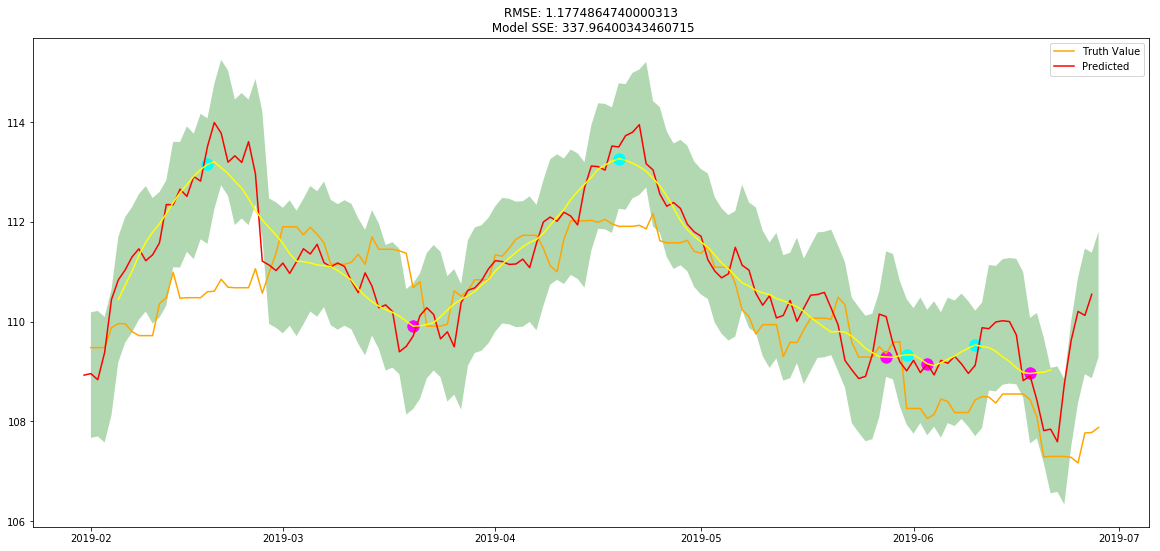

In [163]:
plt.figure(figsize=(20,9))
plt.plot(test_data, label='Truth Value', color='orange')
plt.plot(pred, label='Predicted', color='red')
plt.fill_between(test_data.index, predint_xminus, predint_xplus, facecolor='green', alpha=0.3)
plt.legend(loc='best')
plt.title("RMSE: " + str(np.sqrt(mean_squared_error(test_data, pred))) + "\n Model SSE: " + str(es_results.sse))

roll_number = 12
pred_data = pd.DataFrame(pred.index, columns = ['date'], index=pred.index)
pred_data['value'] = pred.values
pred_data['RO12'] = pred_data['value'].rolling(roll_number).mean()
pred_data['RO12'] = pred_data['RO12'].shift((0-roll_number)//2)
plt.plot(pred_data['RO12'], label='Rolling', color='yellow')
pred_data['grad'] = np.gradient(pred_data['RO12'], 8)
print(pred_data.head(10))
pred_data['turn'] = [1 if (pred_data['grad'].loc[i] >= 0 and pred_data['grad'].loc[i+1] <= 0) else 2 if (pred_data['grad'].loc[i] <= 0 and pred_data['grad'].loc[i+1] >= 0) else 0 for i in pred_data.index]

for i in pred_data.index:
    if (pred_data['turn'].loc[i] == 1):
        plt.scatter(i, pred_data['RO12'].loc[i], color='cyan', s=130)
    elif (pred_data['turn'].loc[i] == 2):
        plt.scatter(i, pred_data['RO12'].loc[i], color='magenta', s=130)
plt.show()

In [124]:
pred_data.head(15)

,date,value,RO12,grad,turn
2019-01-31,2019-01-31,108.928498,NaN,NaN,0
2019-02-01,2019-02-01,108.958792,NaN,NaN,0
2019-02-02,2019-02-02,108.836481,NaN,NaN,0
2019-02-03,2019-02-03,109.381129,NaN,NaN,0
2019-02-04,2019-02-04,110.444153,NaN,NaN,0
2019-02-05,2019-02-05,110.837474,110.443258,NaN,0
2019-02-06,2019-02-06,111.037614,110.728113,0.035423,0
2019-02-07,2019-02-07,111.297424,111.010018,0.037510,0
2019-02-08,2019-02-08,111.459727,111.328266,0.036184,0
2019-02-09,2019-02-09,111.221324,111.588963,0.029122,0


In [170]:
turning = pred_data['turn']
turning_neg = np.where(turning == 1)[0].tolist()
turning_pos = np.where(turning == 2)[0].tolist()

# in cases where there is one extra point
if len(turning_neg) > len(turning_pos):
    del turning_neg[-1]
if len(turning_neg) < len(turning_pos):
    del turning_pos[0]

duration = list(np.subtract(turning_pos, turning_neg))

# If the duration of the 2 (1 and 2) is less then 7 days, do not sell/buy
for idx in reversed([x for x, t in enumerate(duration) if t < 7]):   
    del duration[idx]
    del turning_neg[idx]
    del turning_pos[idx]

# If the seperation of 1 and 2 (['turn‘]) is longer than 3 month, just buy/sell for 3 month
for idx in reversed([x for x, t in enumerate(duration) if t > 90]):   
    duration[idx] = 90

# For Foward, and Option, Both use "the day of turning" as the prespecified date of rate
bought = False

for sell_date, buy_date, dur in zip(turning_neg, turning_pos, duration):   
    if bought:
        print("Selling USD on " + str(pred_data['date'].iloc[sell_date]) + " with price " + str(round(pred_data['value'].iloc[sell_date], 3)) + " Using " + str(dur) + " days FX OPTION.")
        bought = False
    
    print("Buying USD on " + str(pred_data['date'].iloc[buy_date]) + " with price " + str(round(pred_data['value'].iloc[buy_date], 3)) + " Using FX FOWARD.")
    bought = True


Buying USD on 2019-03-20 00:00:00 with price 109.709 Using FX FOWARD.
Selling USD on 2019-04-19 00:00:00 with price 113.501 Using 39 days FX OPTION.
Buying USD on 2019-05-28 00:00:00 with price 110.101 Using FX FOWARD.
Selling USD on 2019-06-10 00:00:00 with price 109.127 Using 8 days FX OPTION.
Buying USD on 2019-06-18 00:00:00 with price 108.917 Using FX FOWARD.


## Hedging Strategy